### Generalized Synthetic Control Method: Causal Inference with Interactive Fixed Effects Models
`Yiqing Xu`

### 1. Framework
---
+ $Y_{it}$ is the outcome.

+ Total number of units $N=N_{co} + N_{tr}$

+ Total number of time periods $T=T_0 + T_1$

+ Staggered treatment adoption

`Assumption 1.` Functional form:

$$
Y_{it} = \delta_{it}D_{it} + x'_{it}\beta + \lambda'_{i}f_{t} + \epsilon_{it},
$$

+ $D_{it}$ indicates treatment status

+ $\delta_{it}$ indicates treatment heterogeneity is allowed (across units and periods)

+ $x_{it}$ contains $k\times 1$ vector of observed covariates

+ $\beta$ is a $k\times 1$ unknown factors, it is constant across units and periods

+ $f_t$ is a $r\times 1$ unobserved common factors, and $\lambda_i$ is an $r\times1$ factor loadings

+ $\lambda'_{i}f_{t}$ is the factor component

### 2. Data generating process (DGP)
---
$$
Y_{it} = \delta_{it}D_{it} + X_{it,1} \cdot 1 + X_{it,2} \cdot 3 + \lambda'_{i}f_{t} + \alpha_{i} + \xi_{t} + 5 + \epsilon_{it}
\tag{3}
$$

+ where $f_t=(f_{it}, f_{2t})$ and $\lambda_i=(\lambda_{i1}, \lambda_{i2})$ are time-varying factors and unit-specific factor loadings. 

+ covariates are (positively) correlated with both the factors and factor loadings
$$
x_{it,k} = 1 + \lambda'_{i}f_{t} + \lambda_{i1} + \lambda_{i2} + f_{1t} + f_{2t} + \eta_{it,k}, \quad k = 1, 2.
$$

+ error term $\epsilon_{it}$, disturbances $\eta_{it,k}$, factors $f_{1t}, f_{2t}$, and time fixed effect $\zeta_t$ are i.i.d normal.

+ $D_{it} = 1$ when $i \in \mathcal{\tau}$ and $t > T_0$, and $D_{it} = 0$ otherwise.

+ The heterogeneous treatment effect is generated by $\delta_{it, t>T_0} = \bar{\delta}_t + e_{it}$,in which $e_{it}$ is i.i.d. $N(0,1)$. $\bar{\delta}_t$ is given by: $[\sigma_{T_0+1}, \sigma_{T_0+2}, \cdots , \sigma_{T_0+10}] = [1, 2, . . . , 10]$.

In [1]:
import pandas as pd
import numpy as np
import cvxpy as cv
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

#### 2.1 Write a DGP function

In [2]:
# we consider two covariates and two factors
def generate_dataframe(N_co, N_tr, T0, T1, w):
    '''
    N_co: number of control units
    N_tr: number of treated units
    T0: number of pre-treatment periods
    T1: number of post-treatment periods
    w: similarity between treated and control units, 1 means identical
    '''
    # Constants
    N = N_co + N_tr
    T = T0 + T1
    ss = np.sqrt(3)

    # Random components
    epsilon, eta, f, xi = [np.random.normal(0, 1, size=s) for s in [(N, T), (2, N, T), (2, T), T]]
    lambda_co, alpha_co = [np.random.uniform(-ss, ss, size=s) for s in [(2, N_co), N_co]]
    lambda_tr, alpha_tr = [np.random.uniform(ss-2*w*ss, 3*ss-2*w*ss, size=s) for s in [(2, N_tr), N_tr]]

    # Factor loadings and unit fixed effects
    lambda_ = np.concatenate([lambda_co, lambda_tr], axis=1)
    alpha = np.concatenate([alpha_co, alpha_tr])

    # Treatment effects and assignment
    tr = np.concatenate([np.zeros(N_co), np.ones(N_tr)])
    delta = np.concatenate([np.zeros(T0), np.arange(1, T1+1)+ np.random.normal(0, 1, T1)]) 

    # Covariates and outcome
    # here the author didn't mention that he scaled some components in the paper but he did in his code
    x1, x2 = [1 + 0.5*(lambda_.T @ f) + 0.25*(lambda_[0].reshape(-1, 1) + lambda_[1].reshape(-1, 1)) + 0.25*(f[0] + f[1]) + eta[i] for i in range(2)]
    y = tr.reshape(-1,1)@delta.reshape(1, -1) + x1*1 + x2*3 + lambda_.T@f + alpha.reshape(-1,1) + xi + epsilon + 5

    # Construct DataFrame
    df = pd.DataFrame({
        'id': np.repeat(np.arange(101, N + 101), T),
        'year': np.tile(np.arange(1, T + 1), N),
        'y': y.flatten(),
        'd': np.repeat(tr, T),
        'x1': x1.flatten(),
        'x2': x2.flatten(),
        'eff': np.tile(delta, N),
        'error': epsilon.flatten(),
        'mu': 5,
        'alpha': np.repeat(alpha, T),
        'xi': np.tile(xi, N),
        'f1': np.tile(f[0], N),
        'l1': np.repeat(lambda_[0], T),
        'f2': np.tile(f[1], N),
        'l2': np.repeat(lambda_[1], T)
    })

    return df

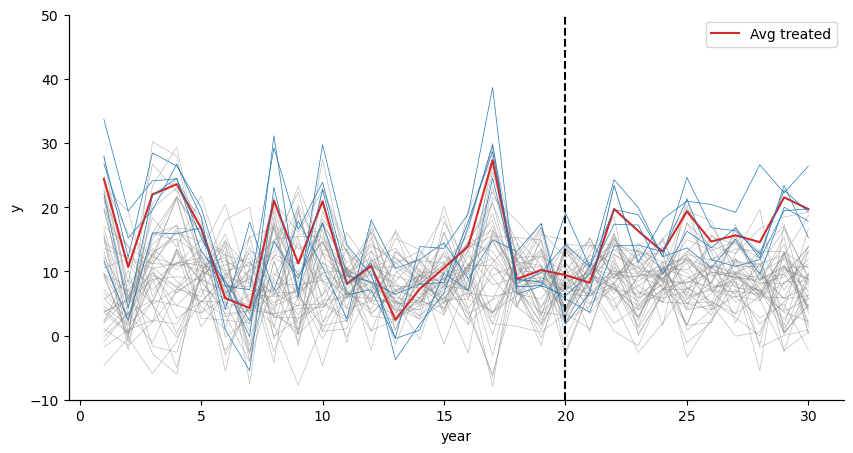

In [3]:
N_co=45
N_tr=5
T0=20
T1=10
w=0.8
datt = generate_dataframe(N_co, N_tr, T0, T1, w)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(x='year', y='y', hue='id', data=datt.query("d==0"), ax=ax, legend=False)
for line in ax.lines:
    line.set_linewidth(0.5)
    line.set_alpha(0.5)
    line.set_color(colors[7])
ax.axvline(x=T0, color='black', linestyle='--')
ax.plot(datt.query("d==1").groupby('year').y.mean(), color=colors[3], label='Avg treated')
ax.legend()
ax.set(ylim=(-10, 50))

ax2 = ax.twinx()
sns.lineplot(x='year', y='y', hue='id', data=datt.query("d==1"), ax=ax2, legend=False)
for line in ax2.lines:
    line.set_linewidth(0.5)
    line.set_alpha(1)
    line.set_color(colors[0])
ax2.set(ylim=(-10, 50))
ax2.yaxis.set_visible(False)

sns.despine()

####  2.2 Data from gsynth package

In [4]:
data = pd.read_csv('data/simdata.csv', index_col=0)
data['d'] = data.groupby('id').D.transform('max')

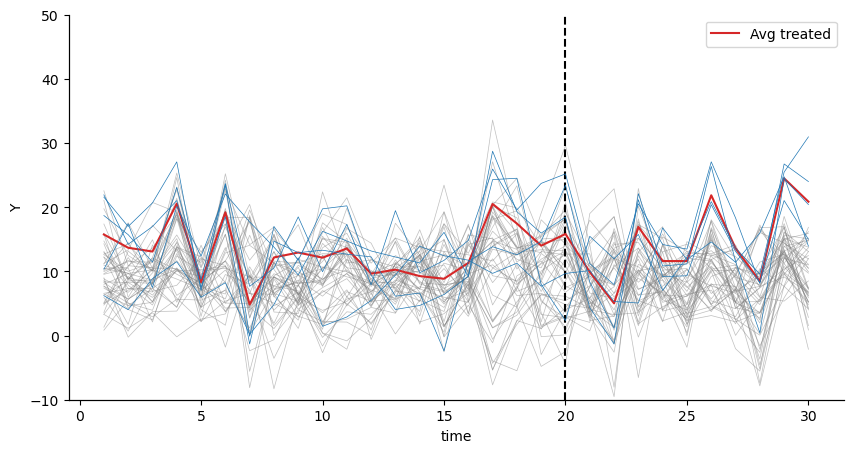

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(x='time', y='Y', hue='id', data=data.query("d==0"), ax=ax, legend=False)
for line in ax.lines:
    line.set_linewidth(0.5)
    line.set_alpha(0.5)
    line.set_color(colors[7])
ax.axvline(x=T0, color='black', linestyle='--')
ax.set(ylim=(-10, 50))
ax.plot(data.query("d==1").groupby('time').Y.mean(), color=colors[3], label='Avg treated')
ax.set(ylim=(-10, 50))

ax.legend()
ax2 = ax.twinx()
sns.lineplot(x='time', y='Y', hue='id', data=data.query("d==1"), ax=ax2, legend=False)
for line in ax2.lines:
    line.set_linewidth(0.5)
    line.set_alpha(1)
    line.set_color(colors[0])
ax2.set(ylim=(-10, 50))
ax2.yaxis.set_visible(False)

sns.despine()

### 3. Assumption for identification
---
`Assumption 2.` Strict exogeneity.

$$
\epsilon_{it} \perp \!\!\! \perp D_{js}, X_{js}, \lambda_j, f_s \quad \forall i, j, t, s.
$$
If this assumption holds then it can be proven:

+ no unobserved time-varying confounder exits

+ past outcomes don't directly affect current outcome (no lagged dependent variable)

+ past treatments don't affect current outcome (no carryover effect)

+ post outcomes dont' affect current treatment (no feadback)

`Assumption 3.` Weak serial dependence of the error terms.

A sufficient condition for Assumption 3 to hold is that the error terms are not only independent of covariates, factors, and factor loadings, but also independent both **across units** and **over time.**

`Assumption 4.` Regularity conditions.

It specifies moment conditions that ensure the convergence of the estimator.

`Assumption 5.` The error terms are cross-sectionally independent and homoscedastic.

### 4. Estimation
--- 
**Step 1.** estimate an IFE model using only the control group data and obtain $\hat{\beta}, \hat{F}, \hat{\Lambda}_{co}$

$$
 (\hat{\beta}, \hat{F}, \hat{\Lambda}_{co}) = \underset{\tilde{\beta}, \tilde{F}, \tilde{\Lambda}_{co}}{\arg\min} \sum_{i \in C} (Y_i - X_i\tilde{\beta} - \tilde{F}\tilde{\lambda}_i)'(Y_i - X_i\tilde{\beta} - \tilde{F}\tilde{\lambda}_i) \\

\text{s.t. } \tilde{F}'\tilde{F}/T = I_r \quad \text{ and } \quad \tilde{\Lambda}_{co}'\tilde{\Lambda}_{co} = \text{diagonal}.
$$

In [6]:
# write a functin to estimate beta F, L
def estimate_parameters(Y, X, r, max_iter=1000, tol=1e-6):
    """
    Estimates parameters of the interactive fixed-effects model using an iterative procedure.
    
    Args:
    Y (np.array): Outcome variable (T, N).
    X (np.array): Regressors (p, T, N).
    r (int): Number of factors.
    max_iter (int): Maximum number of iterations.
    tol (float): Convergence tolerance level.
    
    Returns:
    np.array: Estimated beta coefficients (p, 1).
    np.array: Estimated factors F (T, r).
    np.array: Estimated loadings L (N, r).
    """
    p, N, T = X.shape

    # Reshape Y and X for matrix operations
    y = Y.reshape(N*T, 1, order='F')
    x = X.reshape(p, N*T, order='A').T

    # Initialize parameters
    F = np.random.randn(T, r)
    L = np.random.randn(N, r)

    prev_fun_value = 0
    # perform iterations
    for _ in range(max_iter):
        # compute beta
        beta = np.linalg.inv(x.T @ x) @ (x.T @ (y - (F@L.T).reshape(N*T,1)))

        # update F and L
        residual = (Y - (X.T@beta).reshape(T, N))
        M = (residual @ residual.T) / (N*T)
        s, v, d = np.linalg.svd(M)
        F = s[:, :r]
        L = residual.T @ F / T

        # compute the objective function
        obj_fun = np.sum((Y-(X.T@beta).reshape(T, N) - F@L.T).T @ (Y-(X.T@beta).reshape(T, N) - F@L.T)**2)
        # check for convergence
        if np.abs(obj_fun - prev_fun_value) < tol:
            break
        prev_fun_value = obj_fun
    return beta, F

In [7]:
# prepare contorl data for estimation--beta, F
Y0 = np.array(datt.query("d==0").pivot(index='year', columns='id', values='y'))
X0 = np.empty((2, N_co, T0+T1))
for i in range(0, 2):
    X0[i] = datt.query("d==0").pivot(index='id', columns='year', values=f'x{i+1}')

In [8]:
# suppose we know the number of factors is 2
beta, F = estimate_parameters(Y=Y0, X=X0, r=2, max_iter=1000, tol=1e-6)
beta

array([[2.35728014],
       [4.36562598]])

**Step 2.** estimate factor loadings for each treated unit by minimizing the mean squared error of the predicted treated outcome in pretreatment periods:

\begin{align*}
\hat{\lambda}_i &= \underset{\tilde{\lambda}_i}{\arg\min} (Y_i^0 - X_i^0 \hat{\beta} - \hat{F}_0 \tilde{\lambda}_i)'(Y_i^0 - X_i^0 \hat{\beta} - \hat{F}_0 \tilde{\lambda}_i) \\
&= (\hat{F}_0' \hat{F}_0)^{-1} \hat{F}_0'(Y_i^0 - X_i^0 \hat{\beta}), \quad i \in \mathcal{T},
\end{align*}

In [9]:
# prepare pre-treatment treated data for estimation -- L1(factor loading for treated units)
Y10 = np.array(datt.query(f"d==1 & year<={T0}").pivot(index='year', columns='id', values='y'))
X10 = np.empty((2, N_tr, T0))
for i in range(0, 2):
    X10[i] = datt.query(f"d==1 & year<={T0}").pivot(index='id', columns='year', values=f'x{i+1}')
    
F0 = F[:T0, ]

In [10]:
# solve it by formula
L1 = np.linalg.inv(F0.T @ F0) @ F0.T @ (Y10 - (X10.T @ beta).reshape(T0, N_tr))
pd.DataFrame(L1)

,0,1,2,3,4
0,-17.135021,-4.507774,-19.004408,-1.208587,-13.172331
1,-1.325459,8.669571,1.751692,2.929383,3.204105


In [11]:
# or solve it by minimizing the objective function
import cvxpy as cp
T, N = Y10.shape
# create a cvxpy variable for L
L1_ = cp.Variable((N, 2))
# define the objective function
obj_fun = cp.Minimize(cp.sum_squares(Y10 - (X10.T @ beta).reshape(T, N) - F0 @ L1_.T))
# define the problem and solve it
prob = cp.Problem(obj_fun)
prob.solve()

# print the results
pd.DataFrame(L1_.value.T)

,0,1,2,3,4
0,-17.135021,-4.507774,-19.004408,-1.208587,-13.172331
1,-1.325459,8.669571,1.751692,2.929383,3.204105






**Step 3.** calculate treated counterfactuals based on $\hat{\beta}, \hat{F}, \hat{\lambda}_i$

$$
\hat{Y}_{it}(0) = x'_{it} \hat{\beta} + \hat{\lambda}'_{i} \hat{f}_t \quad i \in \mathcal{T}, \, t > T_0.
$$

In [12]:
# reshape covariates X for treated units post treatment
X11 = np.empty((2, N_tr, T1))
for i in range(0, 2):
    X11[i] = datt.query(f"d==1 & year>{T0}").pivot(index='id', columns='year', values=f'x{i+1}')

In [13]:
# compute counterfactual for treated units post treatment
Y1_syn = (X11.T @ beta).reshape(T1, N_tr) + F[-T1:, ] @ L1

In [14]:
pd.DataFrame(Y1_syn)    

,0,1,2,3,4
0,5.421943,2.398126,10.473483,11.947437,7.970465
1,22.322515,12.709990,19.786537,14.430420,23.725883
2,4.728358,9.216047,15.817854,11.646317,16.166247
3,17.763634,5.630197,6.269745,0.736764,10.029968
4,13.758706,15.630406,22.886012,14.203453,3.732298
5,13.878360,4.972437,10.497090,7.487815,0.757758
6,15.346217,1.696661,12.158273,8.282727,4.980091
7,18.459460,2.367774,3.093833,2.763658,-2.471488
8,15.859843,11.572572,15.356990,18.269725,7.133703
9,14.145937,8.303658,6.598399,-1.447684,6.860398


In [15]:
# reshape covariates X for treated units all time periods
X1 = np.empty((2, N_tr, T0+T1))
for i in range(0, 2):
    X1[i] = datt.query("d==1").pivot(index='id', columns='year', values=f'x{i+1}')

In [16]:
# compute counterfactual for treated units all time periods
Y_syn = (X1.T @ beta).reshape(T0+T1, N_tr) + F @ L1

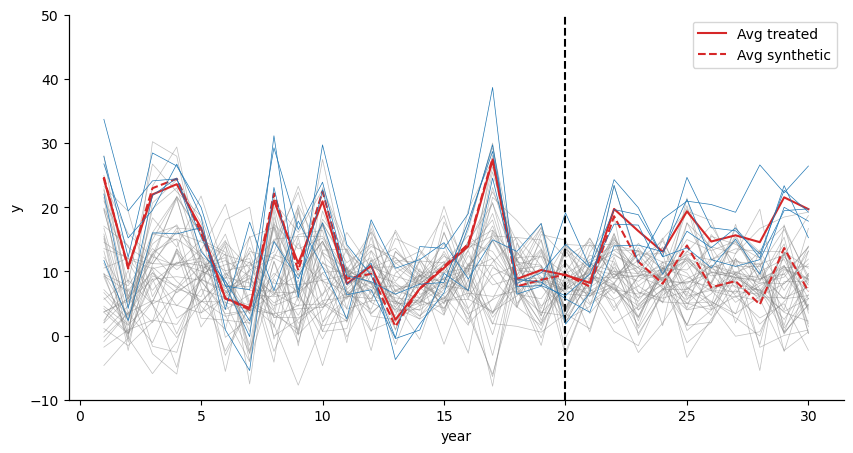

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(x='year', y='y', hue='id', data=datt.query("d==0"), ax=ax, legend=False)
for line in ax.lines:
    line.set_linewidth(0.5)
    line.set_alpha(0.5)
    line.set_color(colors[7])
ax.axvline(x=T0, color='black', linestyle='--')
ax.plot(datt.query("d==1").groupby('year').y.mean(), color=colors[3], label='Avg treated')
ax.legend()
ax.set(ylim=(-10, 50))

sns.lineplot(y=Y_syn.mean(axis=1), x=np.arange(1, T0+T1+1), color=colors[3], linestyle='--', label='Avg synthetic')

ax2 = ax.twinx()
sns.lineplot(x='year', y='y', hue='id', data=datt.query("d==1"), ax=ax2, legend=False)
for line in ax2.lines:
    line.set_linewidth(0.5)
    line.set_alpha(1)
    line.set_color(colors[0])
ax2.set(ylim=(-10, 50))
ax2.yaxis.set_visible(False)

sns.despine()

In [18]:
# compute the residuals between the synthetic control and the treated units
residuals = np.mean(datt.query("d==1").pivot(index='year', columns='id', values='y')-Y_syn, axis=1)
# true treatment effect
eff = datt.query("d==1").groupby('year').eff.mean()

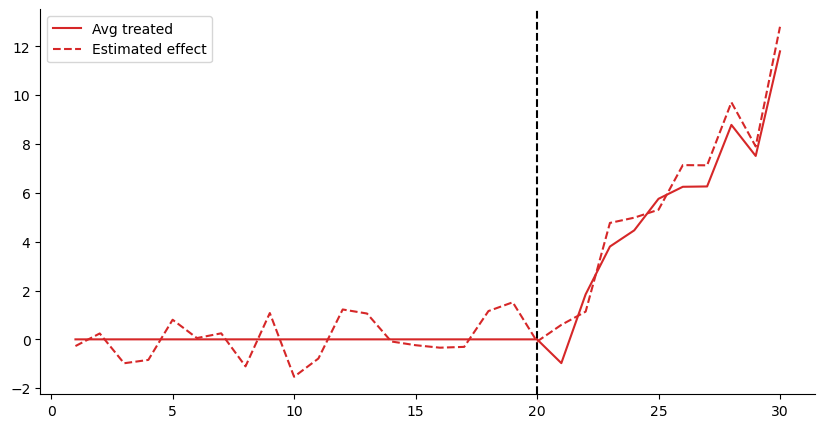

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.axvline(x=T0, color='black', linestyle='--')
ax.plot(eff, color=colors[3], label='Avg treated')
ax.plot(residuals, color=colors[3], linestyle='--', label='Estimated effect')
ax.legend()

sns.despine()

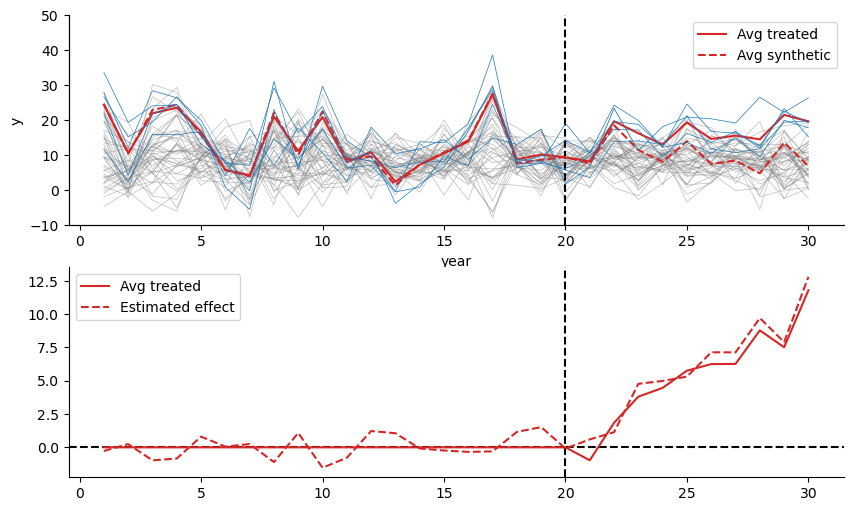

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
sns.lineplot(x='year', y='y', hue='id', data=datt.query("d==0"), ax=ax1, legend=False)
for line in ax1.lines:
    line.set_linewidth(0.5)
    line.set_alpha(0.5)
    line.set_color(colors[7])
ax1.axvline(x=T0, color='black', linestyle='--')
ax1.plot(datt.query("d==1").groupby('year').y.mean(), color=colors[3], label='Avg treated')
ax1.legend()
ax1.set(ylim=(-10, 50))

sns.lineplot(y=Y_syn.mean(axis=1), x=np.arange(1, T0+T1+1), color=colors[3], linestyle='--', label='Avg synthetic', ax=ax1)

ax11 = ax1.twinx()
sns.lineplot(x='year', y='y', hue='id', data=datt.query("d==1"), ax=ax11, legend=False)
for line in ax11.lines:
    line.set_linewidth(0.5)
    line.set_alpha(1)
    line.set_color(colors[0])
ax11.set(ylim=(-10, 50))
ax11.yaxis.set_visible(False)

ax2.axvline(x=T0, color='black', linestyle='--')
ax2.axhline(y=0, color='black', linestyle='--')
ax2.plot(eff, color=colors[3], label='Avg treated')
ax2.plot(residuals, color=colors[3], linestyle='--', label='Estimated effect')
ax2.legend()

sns.despine()

### 5. Cross-validating the number of latent factors (r)
---
In the above analysis, we assume the number of latent factors is r=2, in this section we use cross validation to determine the value of r without knowing it beforehand.

### Appendix
A.3 Estimating an Interactive Fixed-effect Model

As in Equation (1), I assume that the control units follow an interactive fixed-effect model:

$$
Y_{co} = X_{co}\beta + F\Lambda'_{co} + \epsilon_{co},
$$

The least square objective function is
$$
SSR(\beta, F, \Lambda_{co}) = \sum^{N_{co}}_{i=1}(Y_i-X_i\beta-F\lambda_i)'(Y_i-X_i\beta-F\lambda_i)
$$

The goal is to estimate $\beta, F, \Lambda_{co}$ by minimizing the SSR subject to the following
constraints:

$$
F'F/T = T_r, \quad and \quad \Lambda'_{co}\Lambda_{co}=diagonal
$$

A unique solution ($\hat{\beta}, \hat{F}, \hat{\Lambda}_{co}$) to this problem exists. To find the solution, Bai (2009) proposed an iteration scheme that can lead to the unique solution starting from some initial value of $\beta$ (for instance, the least-square dummy-variable (LSDV) estimates) or $F$. In each iteration, given $F$ and $\Lambda_{co}$, the algorithm computes $\beta$:

$$
\hat{\beta}(F, \Lambda) = \left( \sum_{i=1}^{N_{co}} X'_i X_i \right)^{-1} \sum_{i=1}^{N_{co}} X'_i (Y_i - F \Lambda_i),
$$

and given $\beta$, it computes $F$ and $\Lambda_{co}$ from a pure factor model $(Y_i − X_i\beta) = F \lambda_i + \epsilon_i$:

$$
\left[ \frac{1}{N_{co} T} \sum_{i=1}^{N_{co}} (Y_i - X_i\beta)(Y_i - X_i\beta)' \right] \hat{F} = \hat{F}V_{N_{co}T},
$$
$$
\hat{\Lambda}_{co} = \frac{1}{T}(Y - X\beta)'\hat{F},
$$

in which $V_{N_{co}T}$ is a diagonal matrix that consists for the first $r$ largest eigenvalues of the $(N_{co} \times N_{co})$ matrix $\frac{1}{N_{co}T} \sum_{i=1}^{N_{co}} (Y_i - X_i\beta)(Y_i - X_i\beta)'$  and $V_{N_{co}T} = \frac{1}{N_{co}} \hat{\Lambda}'_{co}\hat{\Lambda}_{co}$.
